# Loading the Dataset

In [ ]:
import h5py
import torch

# Path to your .mat file
mat_file_path = 'Downloads/Combustion_data_ME592_Assignment/Aditya_data/combustion_img_13.mat'

with h5py.File(mat_file_path, 'r') as f:
    # Access the datasets
    train_x = f.get("train_set_x")
    train_y = f.get("train_set_y")
    valid_x = f.get("valid_set_x")
    valid_y = f.get("valid_set_y")
    test_x = f.get("test_set_x")
    test_y = f.get("test_set_y")

    # Print dataset insights
    print("Train set shape:", train_x.shape)
    print("Train set data type:", train_x.dtype)
    print("Train label set shape:", train_y.shape)
    print("Train label set data type:", train_y.dtype)

    # Convert datasets to PyTorch tensors and reshape
    train_images = torch.from_numpy(train_x[:].T).float().reshape(-1, 1, 250, 100)
    train_labels = torch.from_numpy(train_y[:]).float()
    valid_images = torch.from_numpy(valid_x[:].T).float().reshape(-1, 1, 250, 100)
    valid_labels = torch.from_numpy(valid_y[:]).float()
    test_images = torch.from_numpy(test_x[:].T).float().reshape(-1, 1, 250, 100)
    test_labels = torch.from_numpy(test_y[:]).float()

    # Print reshaped dataset insights
    print("Transposed train set shape:", train_images.shape)
    print("Transposed valid set shape:", valid_images.shape)
    print("Transposed test set shape:", test_images.shape)



Train set shape: (25000, 54000)
Train set data type: uint8
Train label set shape: (54000, 1)
Train label set data type: uint8
Transposed train set shape: torch.Size([54000, 1, 250, 100])
Transposed valid set shape: torch.Size([9000, 1, 250, 100])
Transposed test set shape: torch.Size([18000, 1, 250, 100])


# Normalising the data

In [ ]:
# Scale to [0, 1]
train_images /= 255.0
valid_images /= 255.0
test_images /= 255.0


Viewing the image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    # Convert from tensor to numpy array
    npimg = img.numpy()
    # Change the dimension order for plotting
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()


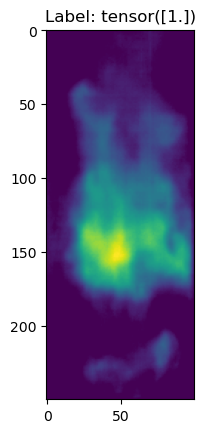

In [ ]:
# Choose an image index
image_index = 0

# Select the image and label after normalization
image_after = train_images[image_index]
label_after = train_labels[image_index]

# Display the image After normalization
imshow(image_after, title=f'Label: {label_after}')


# Creating the DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset instances
train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)


In [ ]:
# Set batch size
batch_size = 64


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


Displaying images one from both stable and unstable class in train loader

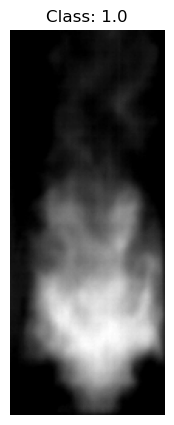

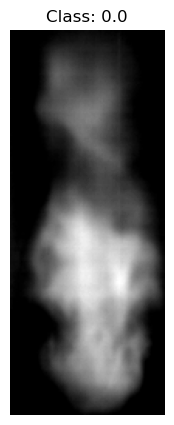

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np


found_classes = set()

# Iterating over batches in the train_loader
for images, labels in train_loader:
    # Iterate over each image and its label in the batch
    for i, label in enumerate(labels):
        # Check if we have found an image for each class
        if len(found_classes) < 2:
            # If this class hasn't been found yet, display the image
            if label.item() not in found_classes:
                # Add the class to the set of found classes
                found_classes.add(label.item())


                image_to_show = images[i].squeeze().cpu().numpy()

                # Display the image
                plt.figure(figsize=(5, 5))
                if image_to_show.ndim == 2:  # Grayscale image
                    plt.imshow(image_to_show, cmap='gray')
                elif image_to_show.ndim == 3:
                    plt.imshow(np.transpose(image_to_show, (1, 2, 0)))
                else:
                    raise ValueError("Unexpected number of dimensions in the image tensor.")

                plt.title(f'Class: {label.item()}')
                plt.axis('off')
                plt.show()

        else:  # If we have found images for both classes, break out of the loop
            break
    if len(found_classes) == 2:
        break

# If we haven't found both classes
if len(found_classes) < 2:
    print("Could not find images for both classes in the provided batch(es).")


##CNN Model with 3 convolution layers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channel = 1 for grayscale images
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 31 * 12, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 31 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)

In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5 = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model5.parameters(), lr=3e-4,weight_decay=1e-5)  # Define the optimizer
loss_per_epoch=[]
val_loss_per_epoch=[]
for i in range(0, 50):
    loss=0
    train_loss = 0
    val_loss = 0
    torch.cuda.empty_cache()
    for batch, (x_batch, y_batch) in enumerate(train_loader):
        y_compute = model5(x_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"y_compute is {y_compute.shape}")
        loss = torch.nn.functional.binary_cross_entropy(y_compute,y_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"loss is {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # take a step in the scheduler
    train_loss = train_loss/len(train_loader)
    loss_per_epoch.append(train_loss)
    val_loss = 0
    model5.eval()
    for batch, (x_batch, y_batch) in enumerate(valid_loader):
        loss = torch.nn.functional.binary_cross_entropy(model5(x_batch.to(device)),y_batch.to(device))
        val_loss += loss.item()
    val_loss = val_loss/len(valid_loader)
    val_loss_per_epoch.append(val_loss)
    model5.train()
    print(f"Epoch {i+1}/50: train loss {train_loss} validation loss {val_loss}\n")



Epoch 1/50: train loss 0.02250795605226282 validation loss 0.0011626851795205429

Epoch 2/50: train loss 0.0030083326379531576 validation loss 0.003537401419261703

Epoch 3/50: train loss 4.975267695507684e-05 validation loss 0.0005876305366507381

Epoch 4/50: train loss 4.253208824170786e-05 validation loss 0.0003151399107503312

Epoch 5/50: train loss 2.2132969884741907e-05 validation loss 0.002246141029260443

Epoch 6/50: train loss 0.0019047978335647627 validation loss 0.0021565242689684447

Epoch 7/50: train loss 2.9413322011420676e-05 validation loss 0.0004392472784375823

Epoch 8/50: train loss 0.00016096712236084737 validation loss 0.0004332248741895504

Epoch 9/50: train loss 1.4195931604133906e-05 validation loss 0.0006399389109569469

Epoch 10/50: train loss 1.1288574287409652e-05 validation loss 0.0008626071754243266

Epoch 11/50: train loss 0.0025587044991317934 validation loss 0.0009786396567194378

Epoch 12/50: train loss 1.6320611408829987e-05 validation loss 0.00091346

Testing the model

In [ ]:
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(test_labels,columns=["Stability"])

In [ ]:
df["Stability"].value_counts()

0.0    10000
1.0     8000
Name: Stability, dtype: int64

In [ ]:
model5.eval()
correct = 0
total = 0
torch.cuda.empty_cache()
count = 0
with torch.no_grad():
    for batch, (x_batch, y_batch) in enumerate(test_loader):
        outputs = model5(x_batch.to(device))
        prediction = (outputs > 0.99).int()
        count += (prediction == y_batch.to(device)).sum().item()
        total+=len(y_batch)
        del outputs
        del x_batch
print(f"count: {count}")
print(f"count: {total}")
print(f"Test Accuracy: {count / total}")



count: 18000
count: 18000
Test Accuracy: 1.0


##CNN Model with 2 convolution layers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channel = 1 for grayscale images
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 62 * 25, 128)  # Adjust the input features based on the output size of conv2
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 62 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)  # Using torch.sigmoid as the final activation function


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = CNNModel2().to(device)
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model2.parameters(), lr=3e-4,weight_decay=1e-5)  # Define the optimizer
loss_per_epoch=[]
val_loss_per_epoch=[]
for i in range(0, 50):
    loss=0
    train_loss = 0
    val_loss = 0
    torch.cuda.empty_cache()
    for batch, (x_batch, y_batch) in enumerate(train_loader):
        y_compute = model2(x_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"y_compute is {y_compute.shape}")
        loss = torch.nn.functional.binary_cross_entropy(y_compute,y_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"loss is {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # take a step in the scheduler
    train_loss = train_loss/len(train_loader)
    loss_per_epoch.append(train_loss)
    val_loss = 0
    model2.eval()
    for batch, (x_batch, y_batch) in enumerate(valid_loader):
        loss = torch.nn.functional.binary_cross_entropy(model2(x_batch.to(device)),y_batch.to(device))
        val_loss += loss.item()
    val_loss = val_loss/len(valid_loader)
    val_loss_per_epoch.append(val_loss)
    model2.train()
    print(f"Epoch {i+1}/50: train loss {train_loss} validation loss {val_loss}\n")

Epoch 1/50: train loss 0.01527091567080038 validation loss 0.0006789608480074912

Epoch 2/50: train loss 0.0006799958869287317 validation loss 0.0004478639043268053

Epoch 3/50: train loss 6.121872608372664e-05 validation loss 0.000679298208670611

Epoch 4/50: train loss 0.023981058132772497 validation loss 0.0018340445768524503

Epoch 5/50: train loss 0.0003822069718816673 validation loss 0.0008728537031694589

Epoch 6/50: train loss 9.099662657805285e-05 validation loss 8.969755784449205e-05

Epoch 7/50: train loss 3.4320140950232006e-05 validation loss 0.0008938448760835786

Epoch 8/50: train loss 4.421755296413462e-05 validation loss 0.0003226663596510749

Epoch 9/50: train loss 1.5957326494934658e-05 validation loss 0.0006929550122192991

Epoch 10/50: train loss 0.0005431986746439278 validation loss 0.0003927297496412447

Epoch 11/50: train loss 7.908664424571305e-06 validation loss 0.00029183141115620456

Epoch 12/50: train loss 6.16257886196118e-06 validation loss 0.000357135351

In [ ]:
model2.eval()
correct = 0
total = 0
torch.cuda.empty_cache()
count = 0
with torch.no_grad():
    for batch, (x_batch, y_batch) in enumerate(test_loader):
        outputs = model2(x_batch.to(device))
        prediction = (outputs > 0.99).int()
        count += (prediction == y_batch.to(device)).sum().item()
        total+=len(y_batch)
        del outputs
        del x_batch
print(f"count: {count}")
print(f"count: {total}")
print(f"Test Accuracy: {count / total}")


count: 17993
count: 18000
Test Accuracy: 0.9996111111111111


##CNN Model with 3 conv layer with dropout layers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channel = 1 for grayscale images
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.5)  # First dropout layer
        self.fc1 = nn.Linear(128 * 31 * 12, 128)
        self.dropout2 = nn.Dropout(p=0.5)  # Second dropout layer
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)  # Apply dropout after the last conv layer
        x = x.view(-1, 128 * 31 * 12)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)  # Apply dropout before the final fully connected layer
        x = self.fc2(x)
        return torch.sigmoid(x)  # Using torch.sigmoid as the final activation function




In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = CNNModel3().to(device)
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model3.parameters(), lr=3e-4,weight_decay=1e-5)  # Define the optimizer
loss_per_epoch=[]
val_loss_per_epoch=[]
for i in range(0, 50):
    loss=0
    train_loss = 0
    val_loss = 0
    torch.cuda.empty_cache()
    for batch, (x_batch, y_batch) in enumerate(train_loader):
        y_compute = model3(x_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"y_compute is {y_compute.shape}")
        loss = torch.nn.functional.binary_cross_entropy(y_compute,y_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"loss is {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # take a step in the scheduler
    train_loss = train_loss/len(train_loader)
    loss_per_epoch.append(train_loss)
    val_loss = 0
    model3.eval()
    for batch, (x_batch, y_batch) in enumerate(valid_loader):
        loss = torch.nn.functional.binary_cross_entropy(model3(x_batch.to(device)),y_batch.to(device))
        val_loss += loss.item()
    val_loss = val_loss/len(valid_loader)
    val_loss_per_epoch.append(val_loss)
    model3.train()
    print(f"Epoch {i+1}/50: train loss {train_loss} validation loss {val_loss}\n")

Epoch 1/50: train loss 0.03370520647108153 validation loss 0.00041751539790513276

Epoch 2/50: train loss 0.005623109924756026 validation loss 0.0012927632559857772

Epoch 3/50: train loss 0.0029309638997393793 validation loss 0.004375507707372739

Epoch 4/50: train loss 0.003524237146805012 validation loss 7.085139108717114e-06

Epoch 5/50: train loss 0.0018238970556956706 validation loss 0.00015128510397189357

Epoch 6/50: train loss 0.0014873377941294849 validation loss 1.7139437244899866e-05

Epoch 7/50: train loss 0.0014509268382239156 validation loss 2.5120772084528117e-05

Epoch 8/50: train loss 0.0010793461329307045 validation loss 4.1914648482695115e-06

Epoch 9/50: train loss 0.0021739522352563255 validation loss 0.0007388935641630816

Epoch 10/50: train loss 0.0012846392394516785 validation loss 0.00015745159773238442

Epoch 11/50: train loss 0.00040570420741701743 validation loss 1.259782395465109e-06

Epoch 12/50: train loss 0.0021323689545886793 validation loss 0.00016379

In [ ]:
model3.eval()
correct = 0
total = 0
torch.cuda.empty_cache()
count = 0
with torch.no_grad():
    for batch, (x_batch, y_batch) in enumerate(test_loader):
        outputs = model2(x_batch.to(device))
        prediction = (outputs > 0.99).int()
        count += (prediction == y_batch.to(device)).sum().item()
        total+=len(y_batch)
        del outputs
        del x_batch
print(f"count: {count}")
print(f"count: {total}")
print(f"Test Accuracy: {count / total}")




count: 17993
count: 18000
Test Accuracy: 0.9996111111111111


In [ ]:
model3.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch, (x_batch, y_batch) in enumerate(test_loader):
        outputs = model3(x_batch.to(device))
        prediction = (outputs > 0.99).int()
        count += (prediction == y_batch.to(device)).sum().item()
        total += len(y_batch)

        # Collect predictions and true labels for confusion matrix
        all_predictions.extend(prediction.cpu().numpy())
        all_true_labels.extend(y_batch.cpu().numpy())

        del outputs, x_batch, prediction  

print(f"count: {count}")
print(f"total: {total}")
print(f"Test Accuracy: {count / total}")

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)


count: 35993
total: 36000
Test Accuracy: 0.9998055555555555
Confusion Matrix:
[[10000     0]
 [    0  8000]]


##CNN model with dropout layer  0.3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel4(nn.Module):
    def __init__(self):
        super(CNNModel4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channel = 1 for grayscale images
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.3)  # First dropout layer
        self.fc1 = nn.Linear(128 * 31 * 12, 128)  # Adjust the input features based on the output of the last conv layer
        self.dropout2 = nn.Dropout(p=0.3)  # Second dropout layer
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)  # Apply dropout after the last conv layer
        x = x.view(-1, 128 * 31 * 12)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)  # Apply dropout before the final fully connected layer
        x = self.fc2(x)
        return torch.sigmoid(x)  # Using torch.sigmoid as the final activation function




In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = CNNModel4().to(device)
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model4.parameters(), lr=3e-4,weight_decay=1e-5)  # Define the optimizer
loss_per_epoch=[]
val_loss_per_epoch=[]
for i in range(0, 50):
    loss=0
    train_loss = 0
    val_loss = 0
    torch.cuda.empty_cache()
    for batch, (x_batch, y_batch) in enumerate(train_loader):
        y_compute = model4(x_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"y_compute is {y_compute.shape}")
        loss = torch.nn.functional.binary_cross_entropy(y_compute,y_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"loss is {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # take a step in the scheduler
    train_loss = train_loss/len(train_loader)
    loss_per_epoch.append(train_loss)
    val_loss = 0
    model4.eval()
    for batch, (x_batch, y_batch) in enumerate(valid_loader):
        loss = torch.nn.functional.binary_cross_entropy(model4(x_batch.to(device)),y_batch.to(device))
        val_loss += loss.item()
    val_loss = val_loss/len(valid_loader)
    val_loss_per_epoch.append(val_loss)
    model4.train()
    print(f"Epoch {i+1}/50: train loss {train_loss} validation loss {val_loss}\n")

Epoch 1/50: train loss 0.045383254480258414 validation loss 0.0005197285620989366

Epoch 2/50: train loss 0.004029703243469613 validation loss 0.008117052251434295

Epoch 3/50: train loss 0.0032919469667111252 validation loss 0.0024811288667167582

Epoch 4/50: train loss 0.003351163255956494 validation loss 0.004115198224413475

Epoch 5/50: train loss 0.0029636486796590497 validation loss 3.4121193816378664e-06

Epoch 6/50: train loss 0.002736662545920157 validation loss 0.00015905355724401375

Epoch 7/50: train loss 0.0015975244281873086 validation loss 0.0023757698627163587

Epoch 8/50: train loss 0.002759558558908701 validation loss 1.7723735719297763e-05

Epoch 9/50: train loss 0.0018052386400143232 validation loss 0.0002928400750372832

Epoch 10/50: train loss 0.001371118142726196 validation loss 0.027424816895337784

Epoch 11/50: train loss 0.0024563224761780557 validation loss 0.00024768725006754357

Epoch 12/50: train loss 0.0012351913440302247 validation loss 9.396813417796866

In [ ]:
model4.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch, (x_batch, y_batch) in enumerate(test_loader):
        outputs = model4(x_batch.to(device))
        prediction = (outputs > 0.99).int()
        count += (prediction == y_batch.to(device)).sum().item()
        total += len(y_batch)

        # Collect predictions and true labels for confusion matrix
        all_predictions.extend(prediction.cpu().numpy())
        all_true_labels.extend(y_batch.cpu().numpy())

        del outputs, x_batch, prediction  

print(f"count: {count}")
print(f"total: {total}")
print(f"Test Accuracy: {count / total}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)


count: 53993
total: 54000
Test Accuracy: 0.9998703703703704
Confusion Matrix:
[[10000     0]
 [    0  8000]]


Displaying the prediction and the image

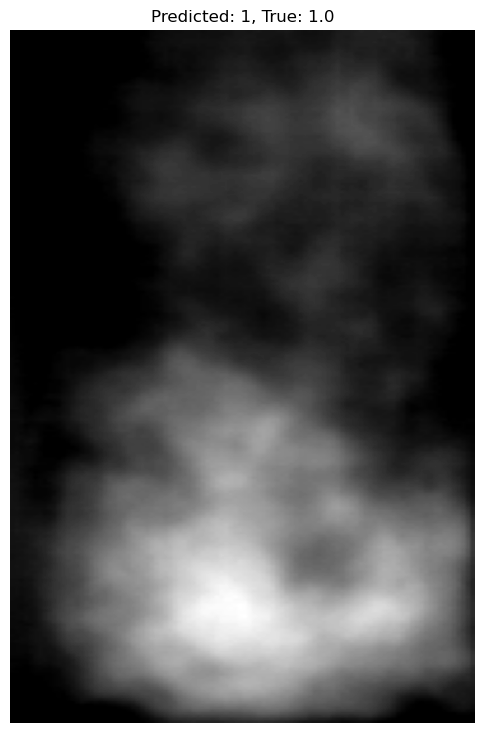

In [ ]:
model4.eval()

# Get one batch of test images
x_batch, y_batch = next(iter(test_loader))

# Select an image and its true label from the batch
image, true_label = x_batch[0], y_batch[0]

image = image.unsqueeze(0).to(device)

# Make a prediction
with torch.no_grad():
    outputs = model4(image)
    predicted_prob = torch.sigmoid(outputs)
    predicted_label = (predicted_prob > 0.5).int().item()

# Convert the image tensor to a format suitable for visualization
image_to_show = image.squeeze().cpu().numpy()

# Display the image
plt.figure(figsize=(6,9))
if image_to_show.ndim == 2:
    plt.imshow(image_to_show, cmap='gray', aspect='auto')
else:
    raise ValueError("The processed image is not 2D as expected.")

plt.title(f'Predicted: {predicted_label}, True: {true_label.item()}')
plt.axis('off')
plt.show()

##CNN Model4 with learning rate changed to 0.001

In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define the device based on CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5 = CNNModel4().to(device)  # Move model to the appropriate device
criterion = nn.CrossEntropyLoss()  # Define the loss function
optimizer = optim.Adam(model5.parameters(), lr=0.001,weight_decay=1e-5)  # Define the optimizer
loss_per_epoch=[]
val_loss_per_epoch=[]
for i in range(0, 50):
    loss=0
    train_loss = 0
    val_loss = 0
    torch.cuda.empty_cache()
    for batch, (x_batch, y_batch) in enumerate(train_loader):
        y_compute = model5(x_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"y_compute is {y_compute.shape}")
        loss = torch.nn.functional.binary_cross_entropy(y_compute,y_batch.to(device))
        # print(f"y_batch is {y_batch.shape}")
        # print(f"loss is {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # take a step in the scheduler
    train_loss = train_loss/len(train_loader)
    loss_per_epoch.append(train_loss)
    val_loss = 0
    model5.eval()
    for batch, (x_batch, y_batch) in enumerate(valid_loader):
        loss = torch.nn.functional.binary_cross_entropy(model5(x_batch.to(device)),y_batch.to(device))
        val_loss += loss.item()
    val_loss = val_loss/len(valid_loader)
    val_loss_per_epoch.append(val_loss)
    model5.train()
    print(f"Epoch {i+1}/50: train loss {train_loss} validation loss {val_loss}\n")

Epoch 1/50: train loss 0.025484909350157757 validation loss 0.0009616635362778762

Epoch 2/50: train loss 0.0038975488640857286 validation loss 0.0027925736621989355

Epoch 3/50: train loss 0.001495994934730255 validation loss 5.5385503823832134e-05

Epoch 4/50: train loss 0.002727267880040639 validation loss 4.800134527398753e-05

Epoch 5/50: train loss 0.0017407882701089305 validation loss 8.384474315713497e-06

Epoch 6/50: train loss 0.000871692236593837 validation loss 9.320345482075703e-07

Epoch 7/50: train loss 0.0017139045438222817 validation loss 0.000640432033396469

Epoch 8/50: train loss 0.00031719369454139375 validation loss 3.737456179873808e-07

Epoch 9/50: train loss 0.002516704890663419 validation loss 4.9460362947872654e-05

Epoch 10/50: train loss 0.0011454870042807183 validation loss 0.001494491216679206

Epoch 11/50: train loss 0.0015822203466372038 validation loss 8.899671984364979e-06

Epoch 12/50: train loss 0.0007178256803233222 validation loss 9.87105057773891

In [ ]:
model5.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch, (x_batch, y_batch) in enumerate(test_loader):
        outputs = model5(x_batch.to(device))
        prediction = (outputs > 0.99).int()
        count += (prediction == y_batch.to(device)).sum().item()
        total += len(y_batch)

        # Collect predictions and true labels for confusion matrix
        all_predictions.extend(prediction.cpu().numpy())
        all_true_labels.extend(y_batch.cpu().numpy())

        del outputs, x_batch, prediction  

print(f"count: {count}")
print(f"total: {total}")
print(f"Test Accuracy: {count / total}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)


count: 89993
total: 90000
Test Accuracy: 0.9999222222222223
Confusion Matrix:
[[10000     0]
 [    0  8000]]
